In [1]:
#learndataa learndataa learndataa learndataa learndataa learndataa learndataa learndataa learndataa

# Predict burned area in a forest fire

### Data Source

    UCI Machine Learning Repository

Forest Fires Data Set
    - License: ---
    - Author:  Paulo Cortez, Aníbal Morais, Department of Information Systems, University of Minho, Portugal.
    - Source Link: https://archive.ics.uci.edu/ml/datasets/Forest+Fires
    - Download: https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/
    - Citation: --- [Cortez and Morais, 2007] P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, Guimarães, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9.
    - Citation: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from scipy import stats
from sklearn import svm


import os

In [3]:
### Check version
import sys
import sklearn
print(sys.version)
!python --version
print("numpy: ", np.__version__)
print("sklearn: ", sklearn.__version__)

3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]
Python 3.8.3
numpy:  1.19.5
sklearn:  0.24.0


In [4]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

### Data

In [52]:
path = '/Users/erv/Desktop/forest_fire/'

In [53]:
dfmain = pd.read_csv(path + 'forestfires.csv', header=0)
print(dfmain.shape)
dfmain.head(2)

(517, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0


In [54]:
dfmain['fire_scale'] = dfmain['area'].apply(lambda x: 'no_fire' if (x==0) else
                                                      'small_fire' if ((x>0)&(x<2))else
                                                      'large_fire'
                                           )
print(dfmain.shape)
dfmain.head(2)

(517, 14)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,fire_scale
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,no_fire
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,no_fire


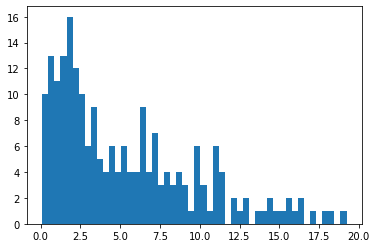

In [55]:
plt.hist(dfmain[(dfmain['area']>0)&(dfmain['area']<20)].area, bins=50)

plt.show()

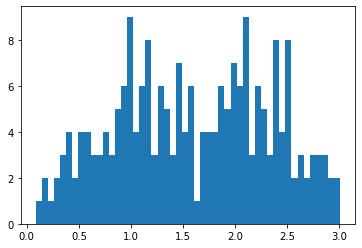

In [26]:
plt.hist(np.log(dfmain[(dfmain['area']>0)&(dfmain['area']<20)].area + 1), bins=50)

plt.show()

<BarContainer object of 12 artists>

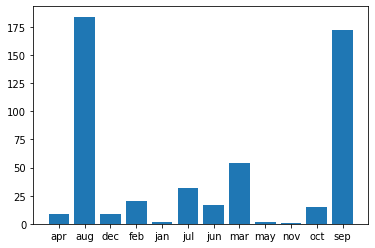

In [13]:
t = dfmain.groupby(['month'])['month'].count()
plt.bar(t.index, t)

In [40]:
dfmain.groupby(['month', 'fire_scale'])['fire_scale'].count()

month  fire_scale
apr    large_fire     4
       no_fire        5
aug    large_fire    71
       no_fire       85
       small_fire    28
dec    large_fire     9
feb    large_fire     9
       no_fire       10
       small_fire     1
jan    no_fire        2
jul    large_fire    12
       no_fire       14
       small_fire     6
jun    large_fire     5
       no_fire        9
       small_fire     3
mar    large_fire    16
       no_fire       35
       small_fire     3
may    large_fire     1
       no_fire        1
nov    no_fire        1
oct    large_fire     5
       no_fire       10
sep    large_fire    76
       no_fire       75
       small_fire    21
Name: fire_scale, dtype: int64

<BarContainer object of 7 artists>

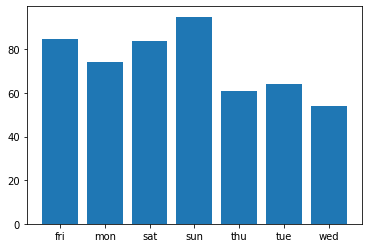

In [14]:
t = dfmain.groupby(['day'])['day'].count()
plt.bar(t.index, t)

# PART I

In [77]:
#d = dfmain.copy()
d = dfmain[dfmain['area']>0].copy()

In [78]:
print(d.shape)
for m in d['month'].unique():
    if((m!='aug')&(m!='sep')):
        temp = d[d['month']==m].sample(300, replace=True)
        d = pd.concat([d, temp], axis=0)

print(d.shape)



(270, 14)
(2670, 14)


<BarContainer object of 10 artists>

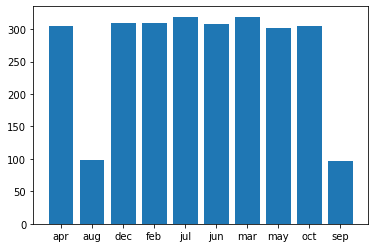

In [79]:
# plot
t = d.groupby(['month'])['month'].count()
plt.bar(t.index, t)

## Regression

### Convert to 1's and 0's

In [80]:
#d = dfmain[dfmain['area']>0].copy()

In [81]:
X = d.drop(['area', 'fire_scale'], axis=1)
y = d['area']

In [82]:
X = pd.get_dummies(X, ['month', 'day'])
X.head(2)

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_apr,month_aug,month_dec,month_feb,month_jul,month_jun,month_mar,month_may,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
138,9,9,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
139,1,4,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [83]:
x_cols_for_scaling = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

### Split



In [84]:
x_train, x_test, y_train, y_test = train_test_split(X, np.log(y+1), shuffle=True)
print(x_train.shape, x_test.shape)

(2002, 27) (668, 27)


#### Split for scaling

In [85]:
x_train_orig = x_train.loc[:, x_cols_for_scaling]
x_train_cat = x_train.drop(x_cols_for_scaling, axis=1)

x_test_orig = x_test.loc[:, x_train_orig.columns]
x_test_cat = x_test.loc[:, x_train_cat.columns]

#### StandardScaler

In [86]:
scl=preprocessing.StandardScaler()
scl.fit(x_train_orig)

x_train_orig = scl.transform(x_train_orig)
x_test_orig = scl.transform(x_test_orig)

# Combine
x_train = np.concatenate([x_train_orig, np.array(x_train_cat)], axis=1)
x_test = np.concatenate([x_test_orig, np.array(x_test_cat)], axis=1)

print(x_train.shape, x_test.shape)

(2002, 27) (668, 27)


#### Model: LinearRegression 

mse:  0.6445
mae:  0.5597
r2:  0.4723


Text(0, 0.5, 'y_pred')

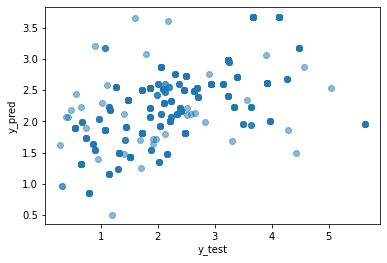

In [87]:
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)

# Predict
y_pred = reg.predict(x_test)

# Score
mse = metrics.mean_squared_error(y_test, y_pred)
print('mse: ', np.round(mse, 4))

mae = metrics.mean_absolute_error(y_test, y_pred)
print('mae: ', np.round(mae, 4))

r2 = metrics.r2_score(y_test, y_pred)
print('r2: ', np.round(r2, 4))


# Plot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')

#### Model: SVMRegression

mse:  0.3326
mae:  0.3026
r2:  0.7277


Text(0, 0.5, 'y_pred')

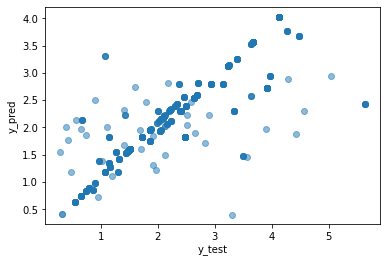

In [88]:
reg = svm.SVR(C=1, kernel='rbf', gamma='auto', max_iter=5e4, cache_size=1000)
reg.fit(x_train, y_train)

# Predict
y_pred = reg.predict(x_test)

# Score
mse = metrics.mean_squared_error(y_test, y_pred)
print('mse: ', np.round(mse, 4))

mae = metrics.mean_absolute_error(y_test, y_pred)
print('mae: ', np.round(mae, 4))

r2 = metrics.r2_score(y_test, y_pred)
print('r2: ', np.round(r2, 4))


# Plot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')

# Part II

## Classification

In [126]:
dfc = dfmain.copy()

In [127]:
dfc.fire_scale.value_counts()

no_fire       247
large_fire    208
small_fire     62
Name: fire_scale, dtype: int64

In [128]:
print(dfc.shape)
for m in dfc['month'].unique():
    if((m!='aug')&(m!='sep')):
        temp = dfc[dfc['month']==m].sample(300, replace=True)
        dfc = pd.concat([dfc, temp], axis=0)

print(dfc.shape)


(517, 14)
(3517, 14)


### Convert to 1's and 0's

In [129]:
#d = dfmain[dfmain['area']>0].copy()

In [130]:
Xc = dfc.drop(['area', 'fire_scale'], axis=1)
yc = dfc['fire_scale']

In [131]:
Xc = pd.get_dummies(Xc, ['month', 'day'])
Xc.head(2)

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [132]:
x_cols_for_scaling = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

### Check

In [133]:
# Zero var
print(Xc.shape)
Xc = Xc[Xc.columns[(Xc.var(axis=0)>0).values]]
print(Xc.shape)

(3517, 29)
(3517, 29)


In [134]:
# Collinearity
print(Xc.shape)
x_corr = Xc.corr()**2

x_upper = x_corr.where(np.triu(np.ones(x_corr.shape), k=1).astype(np.bool))

# r2>0.7
drop_col = [col for col in x_upper.columns if any(x_upper[col] > 0.70)]

Xc = Xc.drop(drop_col, axis=1)
print(Xc.shape)

(3517, 29)
(3517, 29)


### Split



In [135]:
x_train, x_test, y_train, y_test = train_test_split(Xc, yc, 
                                                    shuffle=True, stratify=yc)
print(x_train.shape, x_test.shape)

(2637, 29) (880, 29)


#### Split for scaling

In [136]:
x_train_orig = x_train.loc[:, x_cols_for_scaling]
x_train_cat = x_train.drop(x_cols_for_scaling, axis=1)

x_test_orig = x_test.loc[:, x_train_orig.columns]
x_test_cat = x_test.loc[:, x_train_cat.columns]

#### StandardScaler

In [137]:
scl=preprocessing.StandardScaler()
scl.fit(x_train_orig)

x_train_orig = scl.transform(x_train_orig)
x_test_orig = scl.transform(x_test_orig)

# Combine
x_train = np.concatenate([x_train_orig, np.array(x_train_cat)], axis=1)
x_test = np.concatenate([x_test_orig, np.array(x_test_cat)], axis=1)

print(x_train.shape, x_test.shape)

(2637, 29) (880, 29)


### Model: LogisticRegression

In [139]:
clf = linear_model.LogisticRegression(max_iter=1e7, penalty='elasticnet', solver='saga', l1_ratio=0.75)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acu = metrics.accuracy_score(y_test, y_pred)
print("acu: ", np.round(acu, 4))

cm = metrics.confusion_matrix(y_test, y_pred)
cm

acu:  0.7318


array([[202, 123,   0],
       [ 59, 436,   4],
       [ 24,  26,   6]])

### Model: SVC

In [138]:
clf = svm.SVC(C=1, kernel='rbf', gamma='auto', max_iter=5e4, cache_size=1000)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acu = metrics.accuracy_score(y_test, y_pred)
print("acu: ", np.round(acu, 4))

cm = metrics.confusion_matrix(y_test, y_pred)
cm

acu:  0.8352


array([[264,  61,   0],
       [ 39, 460,   0],
       [ 20,  25,  11]])

# Congratulations on completing the machine learning project!
## Hope you enjoyed the data analysis. Thank you !!!
### Please like, share and subscribe to learndataa

https://www.youtube.com/c/learndataa

In [2]:
#learndataa learndataa learndataa learndataa learndataa learndataa learndataa learndataa learndataa